# Welcome to our look into the Destiny2 Crucible

## Survival Matches

We will be analyzing a dataset of matches to try to determine the effect of kills/match, deaths/match, and assists/match has on probability of winning a match

First, our import statements

In [1]:
from dotenv import load_dotenv
import requests
import os
import json
import mysql.connector
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Next, lets setup our DB connection using a .env file.

In [2]:
%load_ext dotenv
%dotenv

mydb = mysql.connector.connect(
    host = os.getenv('CRUC_DB_HOST'),
    user = os.getenv('CRUC_DB_USER'),
    passwd = os.getenv('CRUC_DB_PASSWD'),
    database = os.getenv('CRUC_DATABASE'),
    auth_plugin='mysql_native_password',
    pool_name='crucible_pool',
    pool_size=5
)
mycursor = mydb.cursor()

Now, let's grab the data and store it in a dataframe.

In [3]:
# get first 1000 rows from DB.
sql = f'SELECT * FROM `matches` LIMIT 1000;'
mycursor.execute(sql)
sqlreturn = mycursor.fetchall()
mydb.close()

# convert to DF 
df = pd.DataFrame(sqlreturn, columns = ['id', 'instanceId', 'team', 'kills', 'deaths', 'assists', 'members', 'duration', 'standing'])
df.head()

,id,instanceId,team,kills,deaths,assists,members,duration,standing
0,1,6494000521,0,38,28,9,3,883,0
1,2,6494000521,1,28,39,7,3,883,1
2,3,6494000682,0,10,33,2,3,468,1
3,4,6494000682,1,33,10,11,3,468,0
4,5,6494002122,0,36,28,12,3,881,0


Let's adjust our kills, deaths, and assists to be per minute instead of per match

In [4]:
df['kills'] = df['kills']/(df['duration']/60)
df['assists'] = df['assists']/(df['duration']/60)
df['deaths'] = df['deaths']/(df['duration']/60)
df.head()

,id,instanceId,team,kills,deaths,assists,members,duration,standing
0,1,6494000521,0,2.582106,1.902605,0.611552,3,883,0
1,2,6494000521,1,1.902605,2.650057,0.475651,3,883,1
2,3,6494000682,0,1.282051,4.230769,0.256410,3,468,1
3,4,6494000682,1,4.230769,1.282051,1.410256,3,468,0
4,5,6494002122,0,2.451759,1.906924,0.817253,3,881,0


So, most of the data is self explanetory.  Standing represents win/loss.  0 = win, 1 = loss.  We don't need the id, instanceId, team, or duration fields so let's drop those columns.  Let's also remove any rows where standing != 1 or 2 and duration < 120 to avoid those outliers

In [5]:
df = df[df.standing != 3]
df = df[df.duration > 120]
df = df.drop(['id', 'instanceId','team','duration'], 1)
df = df.reset_index(drop=True)
df.head()

,kills,deaths,assists,members,standing
0,2.582106,1.902605,0.611552,3,0
1,1.902605,2.650057,0.475651,3,1
2,1.282051,4.230769,0.256410,3,1
3,4.230769,1.282051,1.410256,3,0
4,2.451759,1.906924,0.817253,3,0


Later on we may want to do averages for Kills, deaths, assists but for now we will look at totals, let's creaet a new df without the members field

In [6]:
matches_df = df.drop('members', 1)
matches_df.head()

,kills,deaths,assists,standing
0,2.582106,1.902605,0.611552,0
1,1.902605,2.650057,0.475651,1
2,1.282051,4.230769,0.256410,1
3,4.230769,1.282051,1.410256,0
4,2.451759,1.906924,0.817253,0


Let's visualize kills and assists vs wins

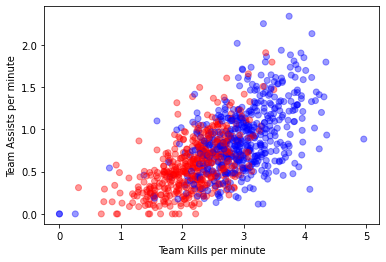

In [11]:
col = np.where(matches_df.standing==0,'b','r')
plt.scatter(matches_df.kills, matches_df.assists,  color=col, alpha=0.4)
plt.xlabel("Team Kills per minute")
plt.ylabel("Team Assists per minute")
plt.show()

Let's look at team Deaths and Assists as well.

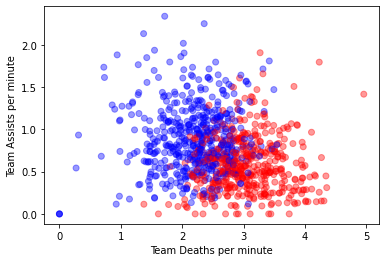

In [12]:
col = np.where(matches_df.standing==0,'b','r')
plt.scatter(matches_df.deaths, matches_df.assists,  color=col, alpha=0.4)
plt.xlabel("Team Deaths per minute")
plt.ylabel("Team Assists per minute")
plt.show()

## Create and Test the Model

In [14]:
X = np.asarray(matches_df[['kills','deaths','assists']])
y = np.asarray(matches_df['standing'])

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (772, 3) (772,)
Test set: (193, 3) (193,)


Now, we need to create and train our model

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

Now, we can create two lists with predicted outcome and probability of outcome

In [17]:
yhat = model.predict(X_test)
yhat_prob = model.predict_proba(X_test)

Let's check the Jaccard index for accuracy

In [18]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.8210526315789474

Let's take a look at the advanced classificatio report

In [19]:
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       109
           1       0.88      0.93      0.90        84

    accuracy                           0.91       193
   macro avg       0.91      0.91      0.91       193
weighted avg       0.91      0.91      0.91       193



So, it seems our model is 91% accurate which is 1% better than the model based on overal values.  This model is better at correctly identifying wins whereas the overal model was better at predicting losses.

Let's view the values for our model

In [24]:
cdf = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print(cdf)

         0         0
0    kills -0.760990
1   deaths  0.834309
2  assists -0.261984


Finally, let's try some different values for C and see if they affect the outcome.

In [25]:
Cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
Results = []
for c in Cs:
    model_temp = LogisticRegression(C=c, solver='liblinear').fit(X_train,y_train)
    yhat_temp = model_temp.predict(X_test)
    Results.append([c, jaccard_score(y_test, yhat_temp)])
results = pd.DataFrame(Results, columns = ['C Value', 'Jaccard Score'])
results

,C Value,Jaccard Score
0,0.001,0.821053
1,0.005,0.821053
2,0.010,0.821053
3,0.050,0.840426
4,0.100,0.849462
5,0.500,0.822917


It looks like .1 is the most accurate C value, let's train the model again using .1 and get the full accuracy

In [26]:
model = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)

yhat = model.predict(X_test)
yhat_prob = model.predict_proba(X_test)

jaccard_score(y_test, yhat)

0.8494623655913979

And this model does indeed provide a higher Jaccard score

In [28]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       109
           1       0.90      0.94      0.92        84

    accuracy                           0.93       193
   macro avg       0.93      0.93      0.93       193
weighted avg       0.93      0.93      0.93       193



And our Model accuracy is now 93%.  That is a good model

And finally, lets check the coefficient values to see weighting

In [29]:
cdf = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print(cdf)

         0         0
0    kills -2.243318
1   deaths  2.415745
2  assists -0.437848


Results:
- Deaths/minute is slightly more important than Kills/minute.
- Assists/minute plays a more minor role in the determinations